# CE-40717: Machine Learning

## HW4-MultiLayer Perceptron (MLP)

The following lines of code will load the [MNIST](http://yann.lecun.com/exdb/mnist/) data and turn them
into numpy arrays, you can print their shape if you like.
You can also transform the data as you wish, including seperating
the training data for cross validation.

If you have the data (on google drive or locally) change the root
address accordingly, if you don't, set download=True but you might encounter
some problems downloading the data.

In [ ]:
import torchvision.datasets as ds
import numpy as np
import pandas as pd
import matplotlib.pyplot as mlt

In [ ]:
data_train = np.array(ds.MNIST(root="./data", train=True, download=True).data)
target_train = np.array(ds.MNIST(root="./data", train=True, download=True).targets)
data_test = np.array(ds.MNIST(root="./data", train=False, download=True).data)
target_test = np.array(ds.MNIST(root="./data", train=False, download=True).targets)

In [ ]:
data_train = data_train/255
data_test = data_test/255
data_train = data_train.reshape(data_train.shape[0],data_train.shape[1]*data_train.shape[2])
data_test = data_test.reshape(data_test.shape[0],data_test.shape[1]*data_test.shape[2])

In [ ]:
def softMax(X):
  e = np.exp(X)
  p = e/np.sum(e, axis=0)
  return p

def relu(X):
  return np.maximum(0,X)

def dReLU(z):
    return (z > 0) * 1

def oneHotEncoding(label):
    n = np.max(label)+1
    v = np.eye(n)[label]
    return v.T

def predict(y):
  return np.argmax(y,0)

def CrossEntropy(predictions, targets, epsilon=1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

def accuracy(y_hat,y):
  return np.sum(y_hat==y)/len(y)

### Part1:
Complete the functions of the MLP class to create
a MultiLayer Perceptron

In [ ]:
class MLP:
    def __init__(self, in_dimensions, hidden_dimensions, out_dimensions):
         self.w1 = np.random.rand(hidden_dimensions,in_dimensions)*np.sqrt(2. /in_dimensions)
         self.b1 = np.random.rand(hidden_dimensions,1)*np.sqrt(2. /in_dimensions)
         self.w2 = np.random.rand(out_dimensions,hidden_dimensions)*np.sqrt(2. /hidden_dimensions)
         self.b2 = np.random.rand(out_dimensions,1)*np.sqrt(2. /in_dimensions)

    def forward(self, x):
        x = x.T
        self.z1_forward = (self.w1 @ x) + self.b1
        self.a1_forward = relu(self.z1_forward)
        self.z2_forward = (self.w2@self.a1_forward)+self.b2
        self.a2_forward = softMax(self.z2_forward)

    def backward(self, loss, y,x):
        m=y.size
        y = oneHotEncoding(y)
        self.z2_backward = self.a2_forward - y
        self.w2_backward = (1. / m)*(self.z2_backward @ self.a1_forward.T)
        self.b2_backward = (1. / m)*np.sum(self.z2_backward)
        self.a1_backward = self.w2.T @ self.z2_backward
        self.z1_backward = self.a1_backward * dReLU(self.z1_forward)
        self.w1_backward = (1. / m)*(self.z1_backward @ x)
        self.b1_backward = (1. / m)* np.sum(self.z1_backward)

    def step(self, lr, lam,x):
        m=x.shape[1]
        self.w2 = self.w2 - lr*self.w2_backward - (1. / m)*(self.w2*lam*lr)
        self.b2 = self.b2 - lr*self.b2_backward
        self.w1 = self.w1 - lr*self.w1_backward - (1. / m)*(self.w1*lam*lr)
        self.b1 = self.b1 - lr*self.b1_backward


### Part2:
Make instances of your network and train them **using l2 regularization and choose the lambda using k-fold cross validation
(set the candidate lambda as you wish)**.

You may choose the hyperparameters (i.e. num of epochs, learning rate etc.)
as you wish. 

Then train a final model on all the training data with the chosen lambda.


In [ ]:
n_epochs = 100
lr = 0.2
k = 10
in_dim = 784
hidden_dim = 32
out_dim =  10
fold_len = int(data_train.shape[0]/k)
lambdas = [0.001,0.1,0.2] 
best_lambda = lambdas[-1]
best_acc = 0
for l in lambdas:
    acc = 0
    loss = 0
    for j in range(k):
        model = MLP(in_dim, hidden_dim, out_dim)
        fold_train_set = np.concatenate((data_train[:j * fold_len],data_train[(j + 1)*fold_len:]))
        fold_train_target = np.concatenate((target_train[:j * fold_len],target_train[(j + 1) * fold_len:]))
        val_set = data_train[j * fold_len:(j + 1) * fold_len]
        val_target = target_train[j * fold_len:(j + 1) * fold_len]

        for i in range(n_epochs):
            model.forward(fold_train_set)
            prediction = predict(model.a2_forward)
            acc = accuracy(prediction, fold_train_target)
            loss = CrossEntropy(prediction,fold_train_target)
            model.backward(loss,fold_train_target,fold_train_set)
            model.step(lr,l,fold_train_set)

        model.forward(val_set)
        prediction = predict(model.a2_forward)
        fold_loss = CrossEntropy(prediction,val_target)
        fold_acc = accuracy(prediction,val_target)

    print("Lambda:", l)
    print("Loss: %.4f Accuracy: %.4f" % (fold_loss, fold_acc))
    print()
    if fold_acc > best_acc:
        best_acc = fold_acc
        best_lambda = l

print("Best lambda is",best_lambda, "with %.4f accuracy" % best_acc)

Lambda: 0.001
Loss: 0.6976 Accuracy: 0.9065

Lambda: 0.1
Loss: 0.5595 Accuracy: 0.9090

Lambda: 0.2
Loss: 0.4939 Accuracy: 0.9065

Best lambda is 0.1 with 0.9090 accuracy


### Part3:
Train a final model using the best lambda on all the training data

In [ ]:
n_epochs = 200
lr = 0.2
model = MLP(in_dim, hidden_dim, out_dim)
losSeq = []
accSeq = []
for i in range(n_epochs):
      model.forward(data_train)
      prediction = predict(model.a2_forward)
      acc = accuracy(prediction,target_train)
      accSeq.append(acc)
      loss = CrossEntropy(prediction,target_train)
      losSeq.append(loss)
      model.backward(loss,target_train,data_train)
      model.step(lr,best_lambda,data_train)

      if (i % 50 == 49):
        print("epoch->", i)
        print("Loss is %.4f And Accuracy is %.4f" % (loss, acc))

epoch-> 49
Loss is 0.9280 And Accuracy is 0.8507
epoch-> 99
Loss is 0.7764 And Accuracy is 0.8840
epoch-> 149
Loss is 0.7125 And Accuracy is 0.8953
epoch-> 199
Loss is 0.6621 And Accuracy is 0.9018


### Part4:

Plot the training loss value and accuracy (mean over all batches each epoch if you're using mini-batches) over epochs
for the final model that is trained on all the training data

No handles with labels found to put in legend.


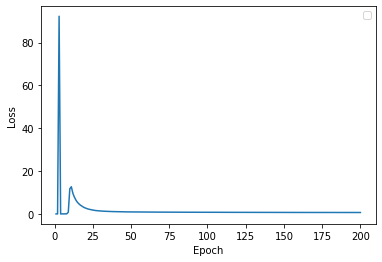

(<matplotlib.legend.Legend at 0x7f456fd01950>, None)

In [ ]:
epochs = range(1, n_epochs+1)
mlt.plot(epochs, losSeq)
mlt.xlabel('Epoch'),mlt.ylabel('Loss')
mlt.legend(),mlt.show()

No handles with labels found to put in legend.


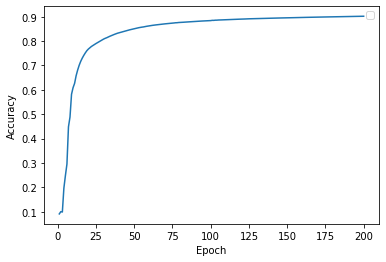

(<matplotlib.legend.Legend at 0x7f456fb829d0>, None)

In [ ]:
mlt.plot(epochs, accSeq)
mlt.xlabel('Epoch'),mlt.ylabel('Accuracy')
mlt.legend(),mlt.show()

Use your network on the test set and report the accuracy, you must get at least 70% accuracy on the test set.

In [ ]:
model.forward(data_test)
prediction = predict(model.a2_forward)
acc = accuracy(prediction, target_test)
print(f"Accuracy: {acc*100} %")

Accuracy: 90.62 %
